In [ ]:
%pip install swig -q
!pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git -q
%pip install --upgrade ipykernel -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.4 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 26.0.0 which is incompatible.


In [ ]:
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
import gym
import numpy as np
import torch
from PIL import Image
import os
from IPython.display import display, Image as IPImage

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
# dir_path = "/content/drive/My Drive/classes/cs7642/"
dir_path = ""

In [ ]:
import json
from dataclasses import dataclass

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.distributions.categorical import Categorical

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [ ]:
### Environment setup ###

## Swap between the 5 layouts here:
# layout = "cramped_room"
# layout = "asymmetric_advantages"
# layout = "coordination_ring"
layout = "forced_coordination"
# layout = "counter_circuit_o_1order"

## Reward shaping is disabled by default; i.e., only the sparse rewards are
## included in the reward returned by the enviornment).  If you'd like to do
## reward shaping (recommended to make the task much easier to solve), this
## data structure provides access to a built-in reward-shaping mechanism within
## the Overcooked environment.  You can, of course, do your own reward shaping
## in lieu of, or in addition to, using this structure. The shaped rewards
## provided by this structure will appear in a different place (see below)
reward_shaping = {
    "PLACEMENT_IN_POT_REW": 3,
    "DISH_PICKUP_REWARD": 3,
    "SOUP_PICKUP_REWARD": 5
}

# Length of Episodes.  Do not modify for your submission!
# Modification will result in a grading penalty!
horizon = 400

In [ ]:
def build_env(layout_):
    # Build the environment.  Do not modify!
    mdp = OvercookedGridworld.from_layout_name(layout_, rew_shaping_params=reward_shaping)
    base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
    env = gym.make("Overcooked-v0", base_env=base_env, featurize_fn=base_env.featurize_state_mdp)
    return env

In [ ]:
def checkpoint(run_name: str, episode_idx: str, run_info: dict,
               total_reward_per_episode: list, average_episode_reward_over_last_100: list,
               agent_0_total_shaped_reward_per_episode: list, agent_1_total_shaped_reward_per_episode: list,
               stats: dict, phase: str):
    """Checkpoints the current info in the file run_name.json

    It simply writes the dictionary of the form:
    {
        episode_idx: [109, 109, 107]
        average_episode_reward_over_last_100: [...]
    }
    """
    run_info[episode_idx] = total_reward_per_episode.copy()
    run_info["average_episode_reward_over_last_100"] = average_episode_reward_over_last_100.copy()
    run_info["agent_0_total_shaped_reward_per_episode"] = agent_0_total_shaped_reward_per_episode.copy()
    run_info["agent_1_total_shaped_reward_per_episode"] = agent_1_total_shaped_reward_per_episode.copy()
    run_info['stats'] = stats

    with open(f"{dir_path}{run_name}_{phase}.json", "w") as f:
        json.dump(run_info, f)

In [ ]:
def get_shaped_rewards_for_agents(info, agent_idx):
    r_shaped = info["shaped_r_by_agent"]
    if agent_idx == 1:
        r_shaped_0 = r_shaped[1]
        r_shaped_1 = r_shaped[0]
    else:
        r_shaped_0 = r_shaped[0]
        r_shaped_1 = r_shaped[1]

    return r_shaped_0, r_shaped_1

In [ ]:
def get_stats_for_agents(info, stat, agent_idx):
    """
    stat: e.g. 'onion_pickup'
    info['episode']['ep_game_stats'][stat] is [[3, 43, 67], [12, 34]]
    where the numbers in the sub-lists are the timestaps at which onion_pickup occured
    """
    stat_values =  info['episode']['ep_game_stats'][stat]
    if agent_idx == 1:
        agent_0_stat_total_over_ep = len(stat_values[1])
        agent_1_stat_total_over_ep = len(stat_values[0])
    else:
        agent_0_stat_total_over_ep = len(stat_values[0])
        agent_1_stat_total_over_ep = len(stat_values[1])

    return agent_0_stat_total_over_ep, agent_1_stat_total_over_ep

## Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

## Implementation

In [ ]:
np.random.seed(42)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, num_actions, gamma, online_model, target_model, loss_fn, batch_size):
        self.replay_buffer = ReplayBuffer(50_000)
        self.state_size = state_size
        self.num_actions = num_actions
        self.gamma = gamma      # discount factor
        self.tau = 0.001        # target model update rate

        # NN hparams
        self.model = online_model
        self.optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        self.loss_fn = loss_fn
        self.batch_size = batch_size

        self.target_model = target_model
        self.target_model.load_state_dict(self.model.state_dict())  # copy the weights

    def select_epsilon_greedy_action(self, state, epsilon=0) -> int:
        """Returns the action to take"""
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_actions)  # random action
        else:
            tensor_state = torch.from_numpy(state).float()
            self.model.eval()
            with torch.no_grad():
                action_values = self.model(tensor_state)
            return torch.argmax(action_values).item()

    def add_experience(self, experience):
        """Adds the experience tuple to the replay buffer

        experience = (state, action, reward, next_state, done)
        where state is a numpy array with type float64
              action is a int and was taken by this agent
              reward is the reward + shaped_reward
              next_state is a numpy array with type float64
              done is a boolean indicating whether episode ended
        """
        self.replay_buffer.append(experience)

    def sample_experiences(self, batch_size):
        """Returns [states, actions, rewards, next_states, dones]

            Where each element is an array of size batch_size.
            For example, element 0 (i.e., states) is an array of
            shape (batch_size, state_size). actions is of shape (batch_size,)
        """
        batch = self.replay_buffer.sample(batch_size)
        return [
            torch.from_numpy(np.array([experience[field_index] for experience in batch])).float()
            for field_index in range(5)
        ]

    def soft_update_target_model(self):
        for online_params, target_params in zip(self.model.parameters(), self.target_model.parameters()):
            target_params.data.copy_((self.tau * online_params.data) +
                                     ((1-self.tau) * target_params.data))

    def training_step(self):
        """Does ones step of Q-learning step over a batch of experiences"""
        self.model.train()

        experiences = self.sample_experiences(self.batch_size)
        states, actions, rewards, next_states, dones = experiences
        next_Q_values = self.target_model(next_states)                          # shape = (batch_size, num_actions)
        max_next_Q_values = next_Q_values.max(1)[0]                             # shape = (batch_size,)
        runs = 1.0 - dones                                 # episode is not done, shape = (batch_size,)
        target_Q_values = rewards + (runs * self.gamma * max_next_Q_values)     # shape = (batch_size,)
        target_Q_values = target_Q_values.unsqueeze(1)                          # shape = (batch_size, 1)

        all_Q_values = self.model(states)                                       # shape = (batch_size, num_actions)
        Q_values = all_Q_values.gather(1, actions.long().unsqueeze(1))          # shape = (batch_size, 1)
        loss = self.loss_fn(target_Q_values.float(), Q_values)                  # float tensor

        self.optimizer.zero_grad()
        loss.backward()             # backward pass
        self.optimizer.step()       # update weights

        self.soft_update_target_model()

In [ ]:
def build_agent(state_size, num_actions):
    batch_size = 64
    gamma = 0.95    # discount_factor
    loss_fn = nn.MSELoss()

    model_ = DQN(state_size, num_actions)
    target_model_ = DQN(state_size, num_actions)

    agent = DQNAgent(state_size, num_actions, gamma, model_, target_model_, loss_fn, batch_size)
    return agent

In [ ]:
def train_agent(run_name: str):
    # Set Up
    env_ = build_env(layout)
    # env_.reset(seed=42)
    input_shape = env_.observation_space.shape
    n_outputs = env_.action_space.n

    agent_0 = build_agent(input_shape[0], n_outputs)
    agent_1 = build_agent(input_shape[0], n_outputs)

    num_episodes = 3000
    TRAIN_EVERY_N_STEPS = 4
    epsilon_decay = 0.995

    # Do training
    total_reward_per_episode = []
    average_episode_reward_over_last_100 = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    run_info = {}
    # Each value is a list of two lists, one for each agent. The value in each
    # sub-list represents the number of, say onion_pickups, in each episode
    # over the training
    stats = {'onion_pickup': [[], []], 'useful_onion_pickup': [[], []], 'potting_onion': [[], []],
             'dish_pickup': [[], []], 'useful_dish_pickup': [[], []],
             'soup_pickup': [[], []], 'soup_delivery': [[], []]}

    epsilon = 1.0
    overall_step = 0

    for episode_idx in range(num_episodes):
        obs = env_.reset()
        state_0, state_1 = obs["both_agent_obs"]
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        for step in range(horizon):
            # 1) Select actions
            action_0 = agent_0.select_epsilon_greedy_action(state_0, epsilon)
            action_1 = agent_1.select_epsilon_greedy_action(state_1, epsilon)

            # 2) Take actions on env
            obs, common_reward, done, info = env_.step([action_0, action_1])

            # 3) Add experience
            next_state_0, next_state_1 = obs["both_agent_obs"]
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env_.agent_idx)
            e_0 = (state_0, action_0, common_reward+r_shaped_0, next_state_0, done)
            e_1 = (state_1, action_1, common_reward+r_shaped_1, next_state_1, done)
            agent_0.add_experience(e_0)
            agent_1.add_experience(e_1)

            # 4) Do training step
            if episode_idx > 2 and overall_step % TRAIN_EVERY_N_STEPS == 0:
                agent_0.training_step()
                agent_1.training_step()

            # 5a) Record reward for transition
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1
            overall_step += 1
            # 5b) Update states
            state_0, state_1 =  next_state_0, next_state_1

            # 6) Stop if done
            if done:
                break

        epsilon = max(epsilon * epsilon_decay, 0.01)

        # Record rewards and stats over the episode
        total_reward_per_episode.append(episode_reward)
        agent_0_total_shaped_reward_per_episode.append(agent_0_shaped_episode_reward)
        agent_1_total_shaped_reward_per_episode.append(agent_1_shaped_episode_reward)
        for stat in stats:
            agent_0_stat_total_over_ep, agent_1_stat_total_over_ep = get_stats_for_agents(info, stat, env_.agent_idx)
            stats[stat][0].append(agent_0_stat_total_over_ep)
            stats[stat][1].append(agent_1_stat_total_over_ep)

        # Checkpoint
        if episode_idx % 100 == 0:
            average_episode_reward_over_last_100.append(np.mean(total_reward_per_episode[-100:]))
        if episode_idx % 50 == 0:
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")

        # Print out debug
        print(f"\rEpisode: {episode_idx} " +
              f"epsilon: {epsilon:.2f} " +
              f"episode_reward: {episode_reward}, " +
              f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
              f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward} "
              f"average_episode_reward_over_last_100: {average_episode_reward_over_last_100[-1]}", end="")

        # Check for convergence
        min_reward = 140
        if ((average_episode_reward_over_last_100[-1] > min_reward and np.all(np.array(total_reward_per_episode[-5:]) >= min_reward)) or
            np.all(np.array(total_reward_per_episode[-20:]) >= min_reward)):
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")
            print(f"\nConverged: Achieved an average reward >140 on episode {episode_idx}")
            break

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats

In [ ]:
run_name = "run26"

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats = train_agent(run_name)

Episode: 2656 epsilon: 0.01 episode_reward: 0, agent_0_shaped_episode_reward: 0, agent_1_shaped_episode_reward: 0 average_episode_reward_over_last_100: 0.0

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

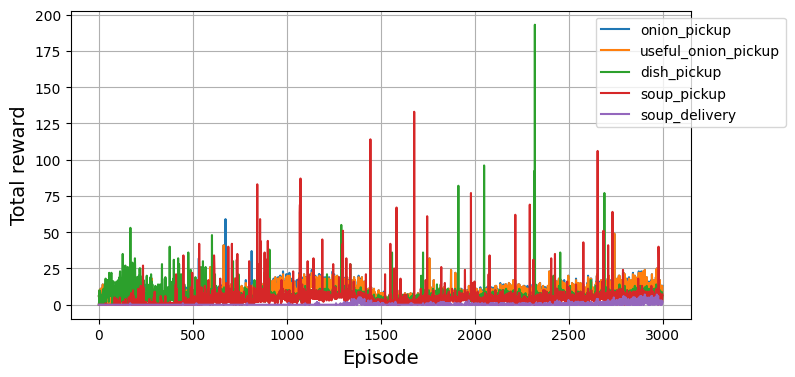

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.array(stats['onion_pickup']).sum(axis=0), label="onion_pickup")
plt.plot(np.array(stats['useful_onion_pickup']).sum(axis=0), label="useful_onion_pickup")
plt.plot(np.array(stats['dish_pickup']).sum(axis=0), label="dish_pickup")
plt.plot(np.array(stats['soup_pickup']).sum(axis=0), label="soup_pickup")
plt.plot(np.array(stats['soup_delivery']).sum(axis=0), label="soup_delivery")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper center', fontsize=10)  # Add legend to distinguish the lines
# plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

In [ ]:
def play_n_episodes(num_episodes: int, agent_0: DQNAgent, agent_1: DQNAgent):
    """After training, simply play n episodes using optimal action"""
    total_reward_per_episode = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    env_ = build_env(layout)

    for episode_idx in range(num_episodes):
        obs = env_.reset()
        state_0, state_1 = obs["both_agent_obs"]
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        for step in range(horizon):
            # state, reward, done, truncated, info = agent.do_one_step(env_, state, epsilon=0)
            # 1) Select actions
            action_0 = agent_0.select_epsilon_greedy_action(state_0, epsilon=0)
            action_1 = agent_1.select_epsilon_greedy_action(state_1, epsilon=0)

            # 2) Take actions on env
            obs, common_reward, done, info = env_.step([action_0, action_1])

            # 3) Update state
            state_0, state_1 = obs["both_agent_obs"]

            # 4) Record rewards
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env_.agent_idx)
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1

        total_reward_per_episode.append(episode_reward)
        agent_0_total_shaped_reward_per_episode.append(agent_0_shaped_episode_reward)
        agent_1_total_shaped_reward_per_episode.append(agent_1_shaped_episode_reward)

        print(f"\rEpisode: {episode_idx}, episode_reward: {episode_reward}", end="")
        print(f"\rEpisode: {episode_idx}, " +
              f"episode_reward: {episode_reward}, " +
              f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
              f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward}", end="")

    checkpoint(run_name, episode_idx, {}, total_reward_per_episode, [],
                agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, {}, "after_training")

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode

Episode: 99, episode_reward: 20, agent_0_shaped_episode_reward: 34, agent_1_shaped_episode_reward: 15

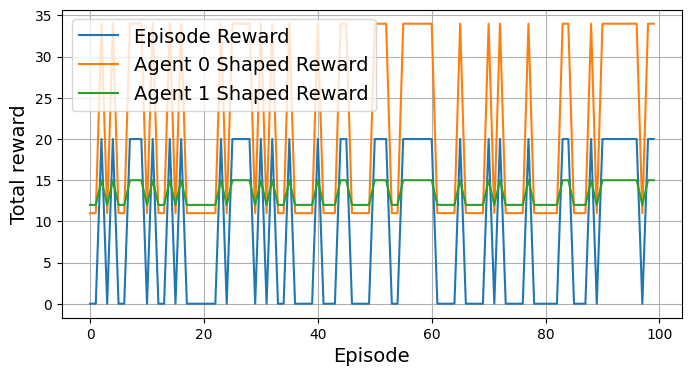

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode = play_n_episodes(100, agent_0, agent_1)

plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_after_training.png")
plt.show()

## Visualize Agents

In [ ]:
### All of the remaining code in this notebook is solely for using the
### built-in Overcooked state visualizer on a trained agent, so that you can see
### a graphical rendering of what your agents are doing. It is not
### necessary to use this.

# The below code is a partcular way to rollout episodes in a format
# compatible with the built-in state visualizer.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self, agent_0, agent_1):
        super(StudentPolicy, self).__init__()
        self.mdp = OvercookedGridworld.from_layout_name(layout, rew_shaping_params=reward_shaping)
        self.base_env = OvercookedEnv.from_mdp(self.mdp, horizon=horizon, info_level=0)
        self.env = gym.make("Overcooked-v0", base_env=self.base_env, featurize_fn=self.base_env.featurize_state_mdp)

        self.agent_0 = agent_0
        self.agent_1 = agent_1

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = self.base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)

        # Example for policy NNs named "PNN0" and "PNN1"
        # with torch.no_grad():
        #   if agent_index == 0:
        #       action_probs = PNN0(input_state)[0].numpy()
        #   else:
        #       action_probs = PNN1(input_state)[0].numpy()

        # Example for Q value NNs named "QNN0" and "QNN1"
        action_probs = np.zeros(self.env.action_space.n)
        action = None
        with torch.no_grad():
          if agent_index == 0:
            action = self.agent_0.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)
          else:
            action = self.agent_1.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)

        action_probs[action] = 1

        # Random deterministic policy
        # action_probs = np.zeros(self.env.action_space.n)
        # action_probs[self.env.action_space.sample()] = 1

        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy(agent_0, agent_1)
policy1 = StudentPolicy(agent_0, agent_1)

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|          | 0/1 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in /usr/local/lib/python3.10/dist-packages/overcooked_ai_py/data/planners/coordination_ring_mp.pkl
It took 0.07512259483337402 seconds to create mp


Avg rew: 220.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


len(trajs): 10


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

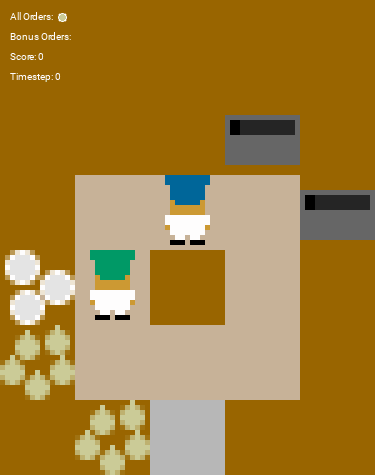

In [ ]:
##############################################################################
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate. Example hooks to Google drive are commented.
img_dir =  "imgs/" # "/content/drive/My Drive/Colab/" + "imgs_" + layout + "/"
ipython_display = True
gif_path = "imgs/imgs.gif" # "/content/drive/My Drive/Colab/" + layout + ".gif"

StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)

## Uncomment for GIF to be generated and stored in 'gif_path'. Requires 'img_dir'
## to point to a directory of saved images.
img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_list = sorted(img_list, key=lambda x: int(x.split('.')[0]))
images = [Image.open(img_dir + img).convert('RGBA') for img in img_list]
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
with open(gif_path, 'rb') as f: display(IPImage(data=f.read(), format='png'))

## Exploration Decay Rates

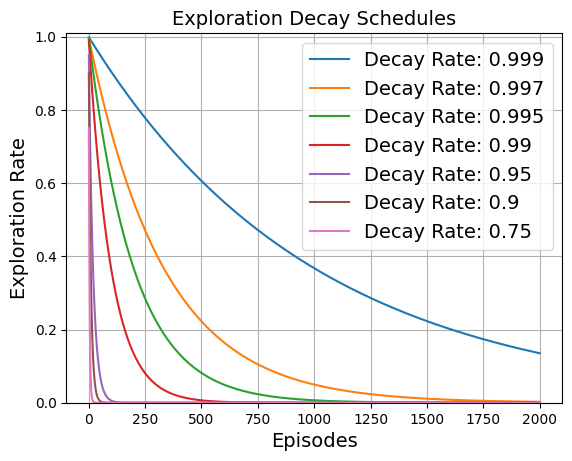

In [ ]:
import matplotlib.pyplot as plt

def plot_exploration_decay(decay_rates):
  """
  This function plots the exploration decay schedules for different decay rates.

  Args:
    decay_rates: A list of decay rates (float) to visualize.
  """
  episodes = range(1, 2001)  # Simulate 1000 episodes

  for decay_rate in decay_rates:
    exploration_rates = [1 * (decay_rate ** i) for i in episodes]
    plt.plot(episodes, exploration_rates, label=f"Decay Rate: {decay_rate}")

  plt.xlabel("Episodes")
  plt.ylabel("Exploration Rate")
  plt.title("Exploration Decay Schedules")
  plt.legend()
  plt.grid(True)
  plt.ylim(0, 1.01)  # Set y-axis limits for better visualization
  plt.show()

# Example usage
decay_rates = [0.999, 0.997, 0.995, 0.990, 0.95, 0.90, 0.75]
plot_exploration_decay(decay_rates)


# PPO Agent

In [ ]:
"""Example Usage
e = EpisodeTrajectory([], [], [], [], [], [], [], [], [])
e.append(np.array([1]), 1, 0.5, 2, np.array([1]), 0.9, False)
"""
@dataclass
class EpisodeTrajectory:
    states: list              # (ep_len, state_size) eg(400, 96)
    actions: list             # (ep_len,) eg(400,)
    action_log_probs: list    # (ep_len,) eg(400,)
    rewards: list             # (ep_len,) eg(400,)
    next_states: list         # (ep_len, state_size) eg(400, 96)
    value_of_states: list     # (ep_len,) eg(400,)
    dones: list               # (ep_len,) eg(400,)
    returns: list             # (ep_len,) eg(400,)
    gaes: list                # (ep_len,) eg(400,)

    def append(self, state: np.array, action: int, action_log_porb: float,
               reward: int, next_state: np.array, value_of_state: float, done: bool):
        self.states.append(state)
        self.actions.append(action)
        self.action_log_probs.append(action_log_porb)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.value_of_states.append(value_of_state)
        self.dones.append(done)

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class PPOAgent:
    def __init__(self, actor: FFNN, critic: FFNN, hparams: dict):
        self.actor = actor
        self.critic = critic
        self.critic_loss_fn = nn.MSELoss()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=hparams['actor_lr'], eps=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=hparams['critic_lr'], eps=1e-5)

        self.gamma = hparams['gamma']       # Discount factor
        self.lambda_ = hparams['lambda']    # Decay factor when calculating GAE
        self.batch_size = hparams['batch_size']
        self.n_epochs = hparams['n_epochs']
        self.epsilon = hparams['epsilon']
        self.target_kl_div = hparams['target_kl_div']
        self.entropy_coeff = hparams['entropy_coeff']
        self.entropy_coeff_start = hparams['entropy_coeff']
        self.max_grad_norm = hparams['max_grad_norm']

    def update_lr(self, lr_decay: float) -> None:
        new_actor_lr = hparams['actor_lr'] * lr_decay
        new_critic_lr = hparams['critic_lr'] * lr_decay
        self.actor_optimizer.param_groups[0]["lr"] = new_actor_lr
        self.critic_optimizer.param_groups[0]["lr"] = new_critic_lr

        self.entropy_coeff = max(self.entropy_coeff_start*lr_decay, 0.1)

    def calculate_disconted_returns(self, rewards: list) -> np.ndarray:
        """Given a list of rewards at each timestep of episode, it calculates
        the return from each timestep
        """
        discounted = np.array(rewards, dtype=float)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += self.gamma * discounted[step + 1]
        return discounted

    def calculate_generalized_advantage_estimates(self, rewards: list, values: list) -> np.ndarray:
        """Given a list of reewards, and values for each timestep,
        returns the Generarlized Estimate Advantage:
        A_t = sigma{l=0, inf} (γλ)^l δ_(t+l)
        A_t^λ = r_t + γ * V(s_{t+1}) - V(s_t) + λ * A_{t+1}^λ

        Eg: calculate_generalized_advantage_estimates(
            [7, 3, 2, 2], [10, 5, 1, 1]) -> array([3.22 , 1.59, 2.87, 1.00])
        """
        next_values = np.concatenate([values[1:], [0]])
        td_errors = [(r + self.gamma * next_val) - val for r, val, next_val in zip(rewards, values, next_values)]

        gaes = [td_errors[-1]]
        for i in reversed(range(len(td_errors)-1)):
            gaes.append(td_errors[i] + (self.lambda_ * self.gamma * gaes[-1]))

        return np.array(gaes[::-1])

    def select_action(self, state: np.ndarray) -> tuple:
        """Returns action (int) and its log probability(float)"""
        tensor_state = torch.from_numpy(state).float()
        self.actor.eval()
        with torch.no_grad():
            logits = self.actor(tensor_state)

        actions_distr = Categorical(logits=logits)
        action = actions_distr.sample()
        action_log_prob = actions_distr.log_prob(action)

        return action.item(), action_log_prob.item()

    def compute_value(self, state: np.ndarray) -> float:
        """Returns the value of the state by calling the critic"""
        tensor_state = torch.from_numpy(state).float()
        self.critic.eval()
        with torch.no_grad():
            value = self.critic(tensor_state)

        return value.item()

    def critic_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of critic training"""
        self.critic.train()
        # 1) Calculate returns
        returns = np.array(trajectory.returns)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_states = torch.from_numpy(np.array(trajectory.states)[mb_indices]).float()  # shape = (batch_size, state_size)
                mb_returns = torch.from_numpy(returns[mb_indices]).float().unsqueeze(1)        # shape = (batch_size, 1)

                mb_predicted_returns = self.critic(mb_states)                               # shape = (batch_size, 1)

                # 4) Compute loss
                loss = self.critic_loss_fn(mb_returns, mb_predicted_returns)                # shape = float tensor

                # 5) Backpropagate the gradients
                self.critic_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()        # update weights

    def actor_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of actor training"""
        self.actor.train()
        # 1) Calculate the Generalized Advantage Estimates
        gaes = np.array(trajectory.gaes)                                        # shape = (episode_length,)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_states = torch.from_numpy(np.array(trajectory.states)[mb_indices]).float()    # shape = (batch_size, state_size)
                mb_actions = torch.from_numpy(np.array(trajectory.actions)[mb_indices])          # shape = (batch_size,)
                mb_action_log_probs = torch.from_numpy(np.array(trajectory.action_log_probs)[mb_indices])  # shape = (batch_size,)
                mb_gaes = torch.from_numpy(gaes[mb_indices]).float()                             # shape = (batch_size,)
                # mb_gaes = (mb_gaes - mb_gaes.mean()) / (mb_gaes.std() + 1e-10)

                # 4) Calculate the new_log_probs
                new_logits = self.actor(mb_states)                                  # shape = (batch_size, 6)
                new_action_distr = Categorical(logits=new_logits)
                new_log_probs = new_action_distr.log_prob(mb_actions)               # shape = (batch_size,)
                entropy = new_action_distr.entropy()                                # shape = (batch_size,)

                # 5) Calculate the ratio
                policy_ratio = torch.exp(new_log_probs - mb_action_log_probs)       # shape = (batch_size,)
                clipped_ratio = policy_ratio.clamp(1-self.epsilon, 1+self.epsilon)

                # 6) Calculate the unclipped and clipped_loss, and then loss
                unclipped_loss = policy_ratio * mb_gaes                             # shape = (batch_size,)
                clipped_loss = clipped_ratio * mb_gaes                              # shape = (batch_size,)
                loss = (-torch.min(unclipped_loss, clipped_loss)).mean()            # shape = float tensor
                entropy_loss = entropy.mean()                                       # shape = float tensor
                loss = loss - (self.entropy_coeff * entropy_loss)                   # shape = float tensor

                # 7) Backpropagate the gradients
                self.actor_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()         # update weights

            # 8) Stop if policy is changing too much
            kl_div = (mb_action_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does an actor, and a critic training step"""
        self.actor_training_step(trajectory)
        self.critic_training_step(trajectory)


In [ ]:
def get_episode_trajectory(n_episodes: int, env, agent_0: PPOAgent, agent_1: PPOAgent, stats: dict):
    """Plays an episode and returns the trajectory, which is a tuple of
    (states, actions, action_log_probs, rewards, next_states, value_of_states, dones)
    Each of these elements is of length: episode_lenght,
        state: (ep_len, state_size) eg(400, 96)
        action: (ep_len,) eg(400,)
        action_log_prob: (ep_len,) eg(400,)
        reward: (ep_len,) eg(400,)
        next_state: (ep_len, state_size) eg(400, 96)
        value_of_state: (ep_len,) eg(400,)
        dones: (ep_len,) eg(400,)
    """
    episode_rewards = []
    agent_0_shaped_episode_rewards = []
    agent_1_shaped_episode_rewards = []

    agent_0_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [])
    agent_1_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [])

    for episode_idx in range(n_episodes):
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        obs = env.reset()
        state_0, state_1 = obs["both_agent_obs"]

        for step in range(horizon):
            # 1) Select actions
            action_0, action_log_prob_0 = agent_0.select_action(state_0)
            action_1, action_log_prob_1 = agent_1.select_action(state_1)

            # 2) Take actions on env
            obs, common_reward, done, info = env.step([action_0, action_1])
            next_state_0, next_state_1 = obs["both_agent_obs"]

            # 3) Record transition data
            value_0 = agent_0.compute_value(state_0)
            value_1 = agent_1.compute_value(state_1)
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env.agent_idx)

            agent_0_trajectory.append(
                state_0, action_0, action_log_prob_0, common_reward+r_shaped_0,
                next_state_0, value_0, done)
            agent_1_trajectory.append(
                state_1, action_1, action_log_prob_1, common_reward+r_shaped_1,
                next_state_1, value_1, done)

            # 5a) Record rewards
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1
            # 5b) Update states
            state_0, state_1 = next_state_0, next_state_1

        # Calculate end of episode metrics: retruns and gaes
        for agent, agent_trajectory in [(agent_0, agent_0_trajectory), (agent_1, agent_1_trajectory)]:
            returns_at_each_episode_timestep = list(agent.calculate_disconted_returns(agent_trajectory.rewards[-step-1:]))
            agent_trajectory.returns += returns_at_each_episode_timestep
            gaes_at_each_episode_timestep = list(
                agent.calculate_generalized_advantage_estimates(
                    agent_trajectory.rewards[-step-1:], agent_trajectory.value_of_states[-step-1:]))
            agent_trajectory.gaes += gaes_at_each_episode_timestep

        # Record rewards and stats over the episode
        episode_rewards.append(episode_reward)
        agent_0_shaped_episode_rewards.append(agent_0_shaped_episode_reward)
        agent_1_shaped_episode_rewards.append(agent_1_shaped_episode_reward)
        for stat in stats:
            agent_0_stat_total_over_ep, agent_1_stat_total_over_ep = get_stats_for_agents(info, stat, env.agent_idx)
            stats[stat][0].append(agent_0_stat_total_over_ep)
            stats[stat][1].append(agent_1_stat_total_over_ep)

    return agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards

In [ ]:
def build_ppo_agent(state_size, num_actions):
    actor = FFNN(state_size, num_actions)
    critic = FFNN(state_size, 1)
    agent = PPOAgent(actor, critic, hparams)

    return agent

In [ ]:
hparams = {
    'gamma': 0.95,
    'lambda': 0.97,
    'batch_size': 512,
    'n_epochs': 6,
    'actor_lr': 4e-4,
    'critic_lr': 4e-4,
    'epsilon': 0.2,
    'target_kl_div': 0.02,
    'entropy_coeff': 0.20,
    'max_grad_norm': 0.5,
    'max_iters': 450,
}

# ppo_layout = 'cramped_room'
# ppo_layout = "asymmetric_advantages"
ppo_layout = "coordination_ring"
# ppo_layout = "forced_coordination"
# ppo_layout = "counter_circuit_o_1order"

In [ ]:
# ## Curriculum learning
# agent_0.actor_optimizer.param_groups[0]["lr"] = hparams['actor_lr']
# agent_0.critic_optimizer.param_groups[0]["lr"] = hparams['critic_lr']
# agent_1.actor_optimizer.param_groups[0]["lr"] = hparams['actor_lr']
# agent_1.critic_optimizer.param_groups[0]["lr"] = hparams['critic_lr']

# agent_0.entropy_coeff = hparams['entropy_coeff']
# agent_1.entropy_coeff = hparams['entropy_coeff']

In [ ]:
# agent_0.entropy_coeff

In [ ]:
def train_ppo_agent(run_name: str):
    # Set Up
    env_ = build_env(ppo_layout)
    # env_.reset(seed=42)
    input_shape = env_.observation_space.shape
    n_outputs = env_.action_space.n

    agent_0 = build_ppo_agent(input_shape[0], n_outputs)
    agent_1 = build_ppo_agent(input_shape[0], n_outputs)

    num_iters = 300
    n_episodes_per_trajectory = 15
    episode_idx = 0

    # Do training
    total_reward_per_episode = []
    average_episode_reward_over_last_100 = [0]
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    run_info = {}
    # Each value is a list of two lists, one for each agent. The value in each
    # sub-list represents the number of, say onion_pickups, in each episode
    # over the training
    stats = {'onion_pickup': [[], []], 'useful_onion_pickup': [[], []], 'potting_onion': [[], []],
             'dish_pickup': [[], []], 'useful_dish_pickup': [[], []],
             'soup_pickup': [[], []], 'soup_delivery': [[], []]}

    for iter_idx in range(num_iters):
        # 1) Play an episode
        agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards = get_episode_trajectory(
            n_episodes_per_trajectory, env_, agent_0, agent_1, stats)

        # 2) Update learning rate
        lr_decay = 1.0 - ((iter_idx) / hparams['max_iters'])
        agent_0.update_lr(lr_decay)
        agent_1.update_lr(lr_decay)

        # 3) Do training step
        agent_0.training_step(agent_0_trajectory)
        agent_1.training_step(agent_1_trajectory)

        # 4) Record results and log info
        total_reward_per_episode += episode_rewards
        agent_0_total_shaped_reward_per_episode += agent_0_shaped_episode_rewards
        agent_1_total_shaped_reward_per_episode += agent_1_shaped_episode_rewards

        # Print out debug
        for episode_reward, agent_0_shaped_episode_reward, agent_1_shaped_episode_reward in zip(
            episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards):
            print(f"\rEpisode: {episode_idx} " +
                  f"episode_reward: {episode_reward}, " +
                  f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
                  f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward} "
                  f"average_episode_reward_over_last_100: {average_episode_reward_over_last_100[-1]}", end="")
            episode_idx += 1

            # Checkpoint
            if episode_idx % 100 == 0:
                average_episode_reward_over_last_100.append(np.mean(total_reward_per_episode[-100:]))
            if episode_idx % 50 == 0:
                checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                        agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")

        # Check for convergence
        min_reward = 140
        if ((average_episode_reward_over_last_100[-1] > min_reward and np.all(np.array(total_reward_per_episode[-5:]) >= min_reward)) or
            np.all(np.array(total_reward_per_episode[-20:]) >= min_reward)):
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")
            print(f"\nConverged: Achieved an average reward >140 on episode {episode_idx}")
            break

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats

In [ ]:
run_name = "run30"

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats = train_ppo_agent(run_name)

Episode: 2504 episode_reward: 140, agent_0_shaped_episode_reward: 57, agent_1_shaped_episode_reward: 67 average_episode_reward_over_last_100: 151.6
Converged: Achieved an average reward >140 on episode 2505


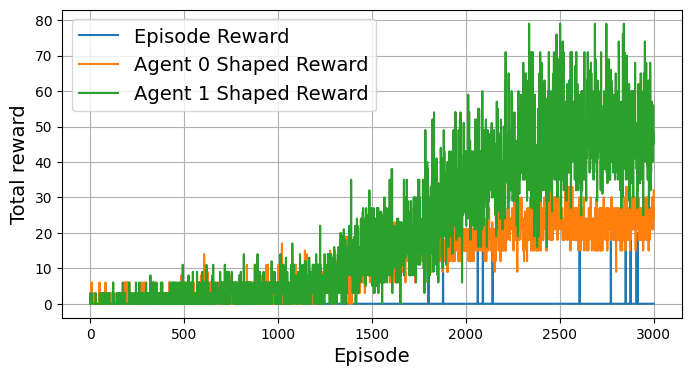

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

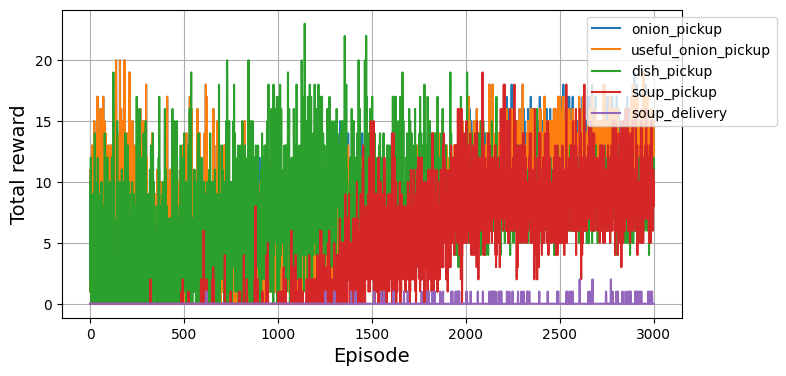

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.array(stats['onion_pickup']).sum(axis=0), label="onion_pickup")
plt.plot(np.array(stats['useful_onion_pickup']).sum(axis=0), label="useful_onion_pickup")
plt.plot(np.array(stats['dish_pickup']).sum(axis=0), label="dish_pickup")
plt.plot(np.array(stats['soup_pickup']).sum(axis=0), label="soup_pickup")
plt.plot(np.array(stats['soup_delivery']).sum(axis=0), label="soup_delivery")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper center', fontsize=10)  # Add legend to distinguish the lines
# plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

In [ ]:
def play_n_episodes(num_episodes: int, agent_0: PPOAgent, agent_1: PPOAgent):
    """After training, simply play n episodes using optimal action"""
    total_reward_per_episode = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    env_ = build_env(ppo_layout)

    for episode_idx in range(num_episodes):
        obs = env_.reset()
        state_0, state_1 = obs["both_agent_obs"]
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        for step in range(horizon):
            # state, reward, done, truncated, info = agent.do_one_step(env_, state, epsilon=0)
            # 1) Select actions
            action_0, action_log_prob_0 = agent_0.select_action(state_0)
            action_1, action_log_prob_1 = agent_1.select_action(state_1)

            # 2) Take actions on env
            obs, common_reward, done, info = env_.step([action_0, action_1])

            # 3) Update state
            state_0, state_1 = obs["both_agent_obs"]

            # 4) Record rewards
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env_.agent_idx)
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1

        total_reward_per_episode.append(episode_reward)
        agent_0_total_shaped_reward_per_episode.append(agent_0_shaped_episode_reward)
        agent_1_total_shaped_reward_per_episode.append(agent_1_shaped_episode_reward)

        print(f"\rEpisode: {episode_idx}, " +
              f"episode_reward: {episode_reward}, " +
              f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
              f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward}", end="")

    checkpoint(run_name, episode_idx, {}, total_reward_per_episode, [],
                agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, {}, "after_training")

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode

Episode: 99, episode_reward: 0, agent_0_shaped_episode_reward: 24, agent_1_shaped_episode_reward: 56

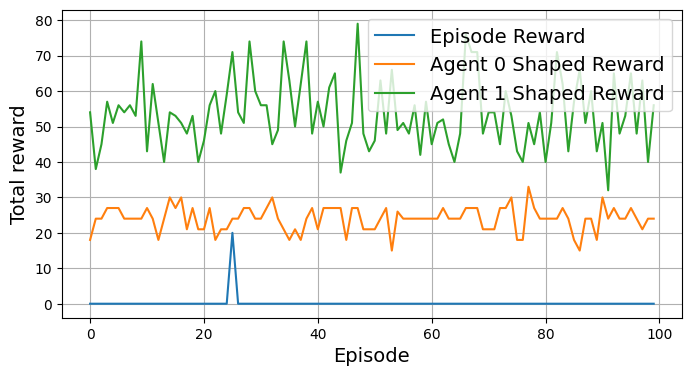

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode = play_n_episodes(100, agent_0, agent_1)

plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_after_training.png")
plt.show()

## Visualize Agents

In [ ]:
### All of the remaining code in this notebook is solely for using the
### built-in Overcooked state visualizer on a trained agent, so that you can see
### a graphical rendering of what your agents are doing. It is not
### necessary to use this.

# The below code is a partcular way to rollout episodes in a format
# compatible with the built-in state visualizer.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self, agent_0, agent_1):
        super(StudentPolicy, self).__init__()
        self.mdp = OvercookedGridworld.from_layout_name(ppo_layout, rew_shaping_params=reward_shaping)
        self.base_env = OvercookedEnv.from_mdp(self.mdp, horizon=horizon, info_level=0)
        self.env = gym.make("Overcooked-v0", base_env=self.base_env, featurize_fn=self.base_env.featurize_state_mdp)

        self.agent_0 = agent_0
        self.agent_1 = agent_1

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = self.base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)

        # Example for policy NNs named "PNN0" and "PNN1"
        action_probs = np.zeros(self.env.action_space.n)
        action = None
        with torch.no_grad():
          if agent_index == 0:
              action, action_log_prob = self.agent_0.select_action(input_state.numpy())
          else:
              action, action_log_prob = self.agent_1.select_action(input_state.numpy())

        # Example for Q value NNs named "QNN0" and "QNN1"
        # action_probs = np.zeros(self.env.action_space.n)
        # action = None
        # with torch.no_grad():
        #   if agent_index == 0:
        #     action = self.agent_0.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)
        #   else:
        #     action = self.agent_1.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)

        action_probs[action] = 1

        # Random deterministic policy
        # action_probs = np.zeros(self.env.action_space.n)
        # action_probs[self.env.action_space.sample()] = 1

        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy(agent_0, agent_1)
policy1 = StudentPolicy(agent_0, agent_1)

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": ppo_layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|          | 0/1 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in /usr/local/lib/python3.10/dist-packages/overcooked_ai_py/data/planners/coordination_ring_mp.pkl
It took 0.09013533592224121 seconds to create mp


Avg rew: 140.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


len(trajs): 10


In [ ]:
##############################################################################
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate. Example hooks to Google drive are commented.
img_dir =  "imgs/" # "/content/drive/My Drive/Colab/" + "imgs_" + layout + "/"
ipython_display = True
gif_path = "imgs/imgs.gif" # "/content/drive/My Drive/Colab/" + layout + ".gif"

StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)

## Uncomment for GIF to be generated and stored in 'gif_path'. Requires 'img_dir'
## to point to a directory of saved images.
img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_list = sorted(img_list, key=lambda x: int(x.split('.')[0]))
images = [Image.open(img_dir + img).convert('RGBA') for img in img_list]
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
with open(gif_path, 'rb') as f: display(IPImage(data=f.read(), format='png'))

interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

# Shared Critic PPO

In [ ]:
"""Example Usage
e = EpisodeTrajectory([], [], [], [], [], [], [], [], [])
e.append(np.array([1]), 1, 0.5, 2, np.array([1]), 0.9, False)
"""
@dataclass
class EpisodeTrajectory:
    states: list              # (ep_len, state_size) eg(400, 96)
    actions: list             # (ep_len,) eg(400,)
    action_log_probs: list    # (ep_len,) eg(400,)
    rewards: list             # (ep_len,) eg(400,)
    next_states: list         # (ep_len, state_size) eg(400, 96)
    value_of_states: list     # (ep_len,) eg(400,)
    dones: list               # (ep_len,) eg(400,)
    returns: list             # (ep_len,) eg(400,)
    gaes: list                # (ep_len,) eg(400,)
    # The following are used for the shared critic
    combined_states: list     # (ep_len, state_size*2) eg(400, 96*2)
    both_agent_rewards: list  # (ep_len,) eg(400,)
    combined_returns: list    # (ep_len,) eg(400,)

    def append(self, state: np.array, action: int, action_log_porb: float,
               reward: int, next_state: np.array, value_of_state: float, done: bool,
               combined_state: np.array, both_agent_reward: int):
        self.states.append(state)
        self.actions.append(action)
        self.action_log_probs.append(action_log_porb)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.value_of_states.append(value_of_state)
        self.dones.append(done)
        self.combined_states.append(combined_state)
        self.both_agent_rewards.append(both_agent_reward)

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

class CriticFFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class SharedCriticPPOAgent:
    def __init__(self, actor: FFNN, critic: CriticFFNN, hparams: dict):
        self.actor = actor
        self.critic = critic
        self.critic_loss_fn = nn.MSELoss()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=hparams['actor_lr'], eps=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=hparams['critic_lr'], eps=1e-5)

        self.gamma = hparams['gamma']       # Discount factor
        self.lambda_ = hparams['lambda']    # Decay factor when calculating GAE
        self.batch_size = hparams['batch_size']
        self.n_epochs = hparams['n_epochs']
        self.epsilon = hparams['epsilon']
        self.target_kl_div = hparams['target_kl_div']
        self.entropy_coeff = hparams['entropy_coeff']
        self.entropy_coeff_start = hparams['entropy_coeff']
        self.max_grad_norm = hparams['max_grad_norm']

    def update_lr(self, lr_decay: float) -> None:
        new_actor_lr = hparams['actor_lr'] * lr_decay
        new_critic_lr = hparams['critic_lr'] * lr_decay
        self.actor_optimizer.param_groups[0]["lr"] = new_actor_lr
        self.critic_optimizer.param_groups[0]["lr"] = new_critic_lr

        self.entropy_coeff = max(self.entropy_coeff_start*lr_decay, 0.1)

    def calculate_disconted_returns(self, rewards: list) -> np.ndarray:
        """Given a list of rewards at each timestep of episode, it calculates
        the return from each timestep
        """
        discounted = np.array(rewards, dtype=float)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += self.gamma * discounted[step + 1]
        return discounted

    def calculate_generalized_advantage_estimates(self, rewards: list, values: list) -> np.ndarray:
        """Given a list of reewards, and values for each timestep,
        returns the Generarlized Estimate Advantage:
        A_t = sigma{l=0, inf} (γλ)^l δ_(t+l)
        A_t^λ = r_t + γ * V(s_{t+1}) - V(s_t) + λ * A_{t+1}^λ

        Eg: calculate_generalized_advantage_estimates(
            [7, 3, 2, 2], [10, 5, 1, 1]) -> array([3.22 , 1.59, 2.87, 1.00])
        """
        next_values = np.concatenate([values[1:], [0]])
        td_errors = [(r + self.gamma * next_val) - val for r, val, next_val in zip(rewards, values, next_values)]

        gaes = [td_errors[-1]]
        for i in reversed(range(len(td_errors)-1)):
            gaes.append(td_errors[i] + (self.lambda_ * self.gamma * gaes[-1]))

        return np.array(gaes[::-1])

    def select_action(self, state: np.ndarray) -> tuple:
        """Returns action (int) and its log probability(float)"""
        tensor_state = torch.from_numpy(state).float()
        self.actor.eval()
        with torch.no_grad():
            logits = self.actor(tensor_state)

        actions_distr = Categorical(logits=logits)
        action = actions_distr.sample()
        action_log_prob = actions_distr.log_prob(action)

        return action.item(), action_log_prob.item()

    def compute_value(self, state: np.ndarray) -> float:
        """Returns the value of the state by calling the critic"""
        tensor_state = torch.from_numpy(state).float()
        self.critic.eval()
        with torch.no_grad():
            value = self.critic(tensor_state)

        return value.item()

    def critic_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of critic training"""
        self.critic.train()
        # 1) Calculate returns
        combined_retruns = np.array(trajectory.combined_returns)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_combined_states = torch.from_numpy(np.array(trajectory.combined_states)[mb_indices]).float()  # shape = (batch_size, state_size)
                mb_combined_retruns = torch.from_numpy(combined_retruns[mb_indices]).float().unsqueeze(1)        # shape = (batch_size, 1)

                mb_predicted_combined_retruns = self.critic(mb_combined_states)                               # shape = (batch_size, 1)

                # 4) Compute loss
                loss = self.critic_loss_fn(mb_combined_retruns, mb_predicted_combined_retruns)                # shape = float tensor

                # 5) Backpropagate the gradients
                self.critic_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()        # update weights

    def actor_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of actor training"""
        self.actor.train()
        # 1) Calculate the Generalized Advantage Estimates
        gaes = np.array(trajectory.gaes)                                        # shape = (episode_length,)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_states = torch.from_numpy(np.array(trajectory.states)[mb_indices]).float()    # shape = (batch_size, state_size)
                mb_actions = torch.from_numpy(np.array(trajectory.actions)[mb_indices])          # shape = (batch_size,)
                mb_action_log_probs = torch.from_numpy(np.array(trajectory.action_log_probs)[mb_indices])  # shape = (batch_size,)
                mb_gaes = torch.from_numpy(gaes[mb_indices]).float()                             # shape = (batch_size,)
                # mb_gaes = (mb_gaes - mb_gaes.mean()) / (mb_gaes.std() + 1e-10)

                # 4) Calculate the new_log_probs
                new_logits = self.actor(mb_states)                                  # shape = (batch_size, 6)
                new_action_distr = Categorical(logits=new_logits)
                new_log_probs = new_action_distr.log_prob(mb_actions)               # shape = (batch_size,)
                entropy = new_action_distr.entropy()                                # shape = (batch_size,)

                # 5) Calculate the ratio
                policy_ratio = torch.exp(new_log_probs - mb_action_log_probs)       # shape = (batch_size,)
                clipped_ratio = policy_ratio.clamp(1-self.epsilon, 1+self.epsilon)

                # 6) Calculate the unclipped and clipped_loss, and then loss
                unclipped_loss = policy_ratio * mb_gaes                             # shape = (batch_size,)
                clipped_loss = clipped_ratio * mb_gaes                              # shape = (batch_size,)
                loss = (-torch.min(unclipped_loss, clipped_loss)).mean()            # shape = float tensor
                entropy_loss = entropy.mean()                                       # shape = float tensor
                loss = loss - (self.entropy_coeff * entropy_loss)                   # shape = float tensor

                # 7) Backpropagate the gradients
                self.actor_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()         # update weights

            # 8) Stop if policy is changing too much
            kl_div = (mb_action_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does an actor, and a critic training step"""
        self.actor_training_step(trajectory)
        self.critic_training_step(trajectory)

In [ ]:
def get_episode_trajectory_shared_critic(n_episodes: int, env, agent_0: SharedCriticPPOAgent, agent_1: SharedCriticPPOAgent, stats: dict):
    """Plays an episode and returns the trajectory, which is a tuple of
    (states, actions, action_log_probs, rewards, next_states, value_of_states, dones)
    Each of these elements is of length: episode_lenght,
        state: (ep_len, state_size) eg(400, 96)
        action: (ep_len,) eg(400,)
        action_log_prob: (ep_len,) eg(400,)
        reward: (ep_len,) eg(400,)
        next_state: (ep_len, state_size) eg(400, 96)
        value_of_state: (ep_len,) eg(400,)
        dones: (ep_len,) eg(400,)
    """
    episode_rewards = []
    agent_0_shaped_episode_rewards = []
    agent_1_shaped_episode_rewards = []

    agent_0_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [], [], [], [])
    agent_1_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [], [], [], [])

    for episode_idx in range(n_episodes):
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        obs = env.reset()
        state_0, state_1 = obs["both_agent_obs"]

        for step in range(horizon):
            # 1) Select actions
            action_0, action_log_prob_0 = agent_0.select_action(state_0)
            action_1, action_log_prob_1 = agent_1.select_action(state_1)

            # 2) Take actions on env
            obs, common_reward, done, info = env.step([action_0, action_1])
            next_state_0, next_state_1 = obs["both_agent_obs"]

            # 3) Record transition data
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env.agent_idx)

            combined_state = np.concatenate((state_0, state_1), axis=0)
            combined_value = agent_0.compute_value(combined_state)

            agent_0_trajectory.append(
                state_0, action_0, action_log_prob_0, common_reward+r_shaped_0,
                next_state_0, combined_value, done,
                combined_state, common_reward+r_shaped_0+r_shaped_1)
            agent_1_trajectory.append(
                state_1, action_1, action_log_prob_1, common_reward+r_shaped_1,
                next_state_1, combined_value, done,
                combined_state, common_reward+r_shaped_0+r_shaped_1)

            # 5a) Record rewards
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1
            # 5b) Update states
            state_0, state_1 = next_state_0, next_state_1

        # Calculate end of episode metrics: retruns and gaes
        for agent, agent_trajectory in [(agent_0, agent_0_trajectory), (agent_1, agent_1_trajectory)]:
            # a) caculate retruns
            returns_at_each_episode_timestep = list(agent.calculate_disconted_returns(agent_trajectory.rewards[-step-1:]))
            agent_trajectory.returns += returns_at_each_episode_timestep
            # b) calculate combined returns
            combined_returns_at_each_episode_timestep = list(agent.calculate_disconted_returns(agent_trajectory.both_agent_rewards[-step-1:]))
            agent_trajectory.combined_returns += combined_returns_at_each_episode_timestep
            # c) calculate gaes
            gaes_at_each_episode_timestep = list(
                agent.calculate_generalized_advantage_estimates(
                    agent_trajectory.both_agent_rewards[-step-1:], agent_trajectory.value_of_states[-step-1:]))
            agent_trajectory.gaes += gaes_at_each_episode_timestep

        # Record rewards and stats over the episode
        episode_rewards.append(episode_reward)
        agent_0_shaped_episode_rewards.append(agent_0_shaped_episode_reward)
        agent_1_shaped_episode_rewards.append(agent_1_shaped_episode_reward)
        for stat in stats:
            agent_0_stat_total_over_ep, agent_1_stat_total_over_ep = get_stats_for_agents(info, stat, env.agent_idx)
            stats[stat][0].append(agent_0_stat_total_over_ep)
            stats[stat][1].append(agent_1_stat_total_over_ep)

    return agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards

In [ ]:
hparams = {
    'gamma': 0.99,
    'lambda': 0.97,
    'batch_size': 512,
    'n_epochs': 6,
    'actor_lr': 4e-4,
    'critic_lr': 4e-4,
    'epsilon': 0.2,
    'target_kl_div': 0.02,
    'entropy_coeff': 0.20,
    'max_grad_norm': 0.5,
    'max_iters': 300,
}

# ppo_layout = 'cramped_room'
# ppo_layout = "asymmetric_advantages"
ppo_layout = "coordination_ring"
# ppo_layout = "forced_coordination"
# ppo_layout = "counter_circuit_o_1order"

In [ ]:
# ## Curriculum learning
# agent_0.actor_optimizer.param_groups[0]["lr"] = hparams['actor_lr']
# agent_0.critic_optimizer.param_groups[0]["lr"] = hparams['critic_lr']
# agent_1.actor_optimizer.param_groups[0]["lr"] = hparams['actor_lr']
# agent_1.critic_optimizer.param_groups[0]["lr"] = hparams['critic_lr']

# agent_0.entropy_coeff = hparams['entropy_coeff']
# agent_1.entropy_coeff = hparams['entropy_coeff']

# agent_0.entropy_coeff

In [ ]:
def train_shared_critic_ppo_agent(run_name: str):
    # Set Up
    env_ = build_env(ppo_layout)
    # env_.reset(seed=42)
    input_shape = env_.observation_space.shape
    n_outputs = env_.action_space.n

    shared_critic = CriticFFNN(input_shape[0]*2, 1)
    agent_0 = SharedCriticPPOAgent(FFNN(input_shape[0], n_outputs), shared_critic, hparams)
    agent_1 = SharedCriticPPOAgent(FFNN(input_shape[0], n_outputs), shared_critic, hparams)

    num_iters = 300
    n_episodes_per_trajectory = 10
    episode_idx = 0

    # Do training
    total_reward_per_episode = []
    average_episode_reward_over_last_100 = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    run_info = {}
    # Each value is a list of two lists, one for each agent. The value in each
    # sub-list represents the number of, say onion_pickups, in each episode
    # over the training
    stats = {'onion_pickup': [[], []], 'useful_onion_pickup': [[], []], 'potting_onion': [[], []],
             'dish_pickup': [[], []], 'useful_dish_pickup': [[], []],
             'soup_pickup': [[], []], 'soup_delivery': [[], []]}

    for iter_idx in range(num_iters):
        # 1) Play an episode
        agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards = get_episode_trajectory_shared_critic(
            n_episodes_per_trajectory, env_, agent_0, agent_1, stats)

        # 2) Update learning rate
        lr_decay = 1.0 - ((iter_idx) / hparams['max_iters'])
        agent_0.update_lr(lr_decay)
        agent_1.update_lr(lr_decay)

        # 3) Do training step
        agent_0.actor_training_step(agent_0_trajectory)
        agent_1.actor_training_step(agent_1_trajectory)
        agent_0.critic_training_step(agent_0_trajectory)    # As it is a shred critic, we can call on both agent_0 or agent_1
        agent_1.critic_training_step(agent_1_trajectory)    # As it is a shred critic, we can call on both agent_0 or agent_1

        # 4) Record results and log info
        total_reward_per_episode += episode_rewards
        agent_0_total_shaped_reward_per_episode += agent_0_shaped_episode_rewards
        agent_1_total_shaped_reward_per_episode += agent_1_shaped_episode_rewards

        # Checkpoint
        if episode_idx % 100 == 0:
            average_episode_reward_over_last_100.append(np.mean(total_reward_per_episode[-100:]))
        if episode_idx % 50 == 0:
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")

        # Print out debug
        for episode_reward, agent_0_shaped_episode_reward, agent_1_shaped_episode_reward in zip(
            episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards):
            print(f"\rEpisode: {episode_idx} " +
                  f"episode_reward: {episode_reward}, " +
                  f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
                  f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward} "
                  f"average_episode_reward_over_last_100: {average_episode_reward_over_last_100[-1]}", end="")
            episode_idx += 1

        # Check for convergence
        min_reward = 140
        if ((average_episode_reward_over_last_100[-1] > min_reward and np.all(np.array(total_reward_per_episode[-5:]) >= min_reward)) or
            np.all(np.array(total_reward_per_episode[-20:]) >= min_reward)):
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")
            print(f"\nConverged: Achieved an average reward >140 on episode {episode_idx}")
            break

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats

In [ ]:
run_name = "run29"

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent_0, agent_1, stats = train_shared_critic_ppo_agent(run_name)

Episode: 2619 episode_reward: 140, agent_0_shaped_episode_reward: 48, agent_1_shaped_episode_reward: 62 average_episode_reward_over_last_100: 141.6
Converged: Achieved an average reward >140 on episode 2620


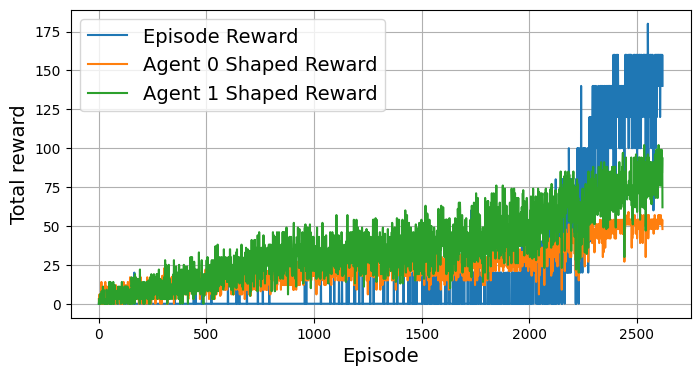

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

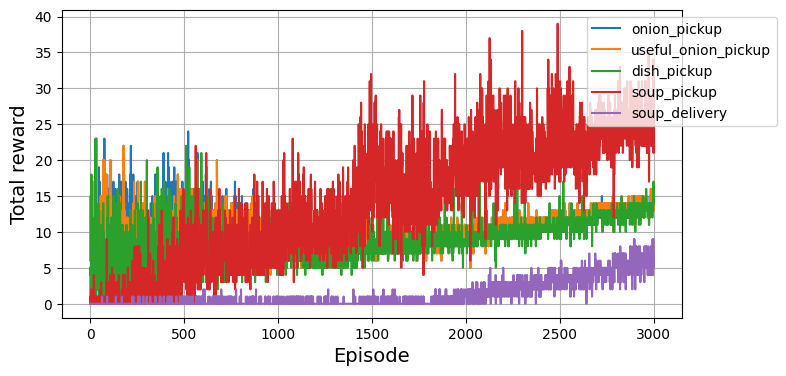

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.array(stats['onion_pickup']).sum(axis=0), label="onion_pickup")
plt.plot(np.array(stats['useful_onion_pickup']).sum(axis=0), label="useful_onion_pickup")
plt.plot(np.array(stats['dish_pickup']).sum(axis=0), label="dish_pickup")
plt.plot(np.array(stats['soup_pickup']).sum(axis=0), label="soup_pickup")
plt.plot(np.array(stats['soup_delivery']).sum(axis=0), label="soup_delivery")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper center', fontsize=10)  # Add legend to distinguish the lines
# plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

In [ ]:
def play_n_episodes(num_episodes: int, agent_0: SharedCriticPPOAgent, agent_1: SharedCriticPPOAgent):
    """After training, simply play n episodes using optimal action"""
    total_reward_per_episode = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    env_ = build_env(ppo_layout)

    for episode_idx in range(num_episodes):
        obs = env_.reset()
        state_0, state_1 = obs["both_agent_obs"]
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        for step in range(horizon):
            # state, reward, done, truncated, info = agent.do_one_step(env_, state, epsilon=0)
            # 1) Select actions
            action_0, action_log_prob_0 = agent_0.select_action(state_0)
            action_1, action_log_prob_1 = agent_1.select_action(state_1)

            # 2) Take actions on env
            obs, common_reward, done, info = env_.step([action_0, action_1])

            # 3) Update state
            state_0, state_1 = obs["both_agent_obs"]

            # 4) Record rewards
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env_.agent_idx)
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1

        total_reward_per_episode.append(episode_reward)
        agent_0_total_shaped_reward_per_episode.append(agent_0_shaped_episode_reward)
        agent_1_total_shaped_reward_per_episode.append(agent_1_shaped_episode_reward)

        print(f"\rEpisode: {episode_idx}, " +
              f"episode_reward: {episode_reward}, " +
              f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
              f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward}", end="")

    checkpoint(run_name, episode_idx, {}, total_reward_per_episode, [],
                agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, {}, "after_training")

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode

Episode: 99, episode_reward: 140, agent_0_shaped_episode_reward: 57, agent_1_shaped_episode_reward: 84

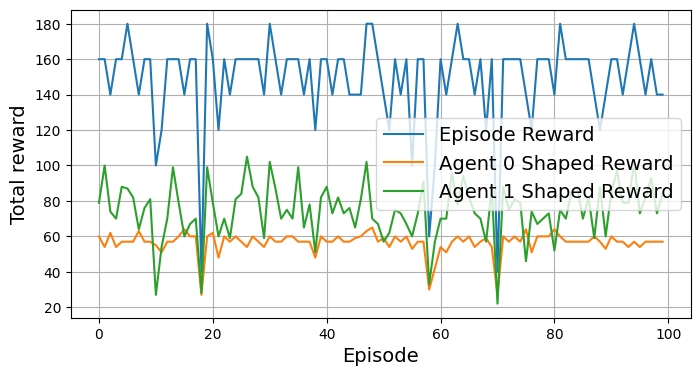

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode = play_n_episodes(100, agent_0, agent_1)

plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_after_training.png")
plt.show()

## Visualize Agents

In [ ]:
### All of the remaining code in this notebook is solely for using the
### built-in Overcooked state visualizer on a trained agent, so that you can see
### a graphical rendering of what your agents are doing. It is not
### necessary to use this.

# The below code is a partcular way to rollout episodes in a format
# compatible with the built-in state visualizer.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self, agent_0, agent_1):
        super(StudentPolicy, self).__init__()
        self.mdp = OvercookedGridworld.from_layout_name(ppo_layout, rew_shaping_params=reward_shaping)
        self.base_env = OvercookedEnv.from_mdp(self.mdp, horizon=horizon, info_level=0)
        self.env = gym.make("Overcooked-v0", base_env=self.base_env, featurize_fn=self.base_env.featurize_state_mdp)

        self.agent_0 = agent_0
        self.agent_1 = agent_1

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = self.base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)

        # Example for policy NNs named "PNN0" and "PNN1"
        action_probs = np.zeros(self.env.action_space.n)
        action = None
        with torch.no_grad():
          if agent_index == 0:
              action, action_log_prob = self.agent_0.select_action(input_state.numpy())
          else:
              action, action_log_prob = self.agent_1.select_action(input_state.numpy())

        # Example for Q value NNs named "QNN0" and "QNN1"
        # action_probs = np.zeros(self.env.action_space.n)
        # action = None
        # with torch.no_grad():
        #   if agent_index == 0:
        #     action = self.agent_0.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)
        #   else:
        #     action = self.agent_1.select_epsilon_greedy_action(input_state.numpy(), epsilon=0)

        action_probs[action] = 1

        # Random deterministic policy
        # action_probs = np.zeros(self.env.action_space.n)
        # action_probs[self.env.action_space.sample()] = 1

        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy(agent_0, agent_1)
policy1 = StudentPolicy(agent_0, agent_1)

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": ppo_layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|          | 0/1 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in /usr/local/lib/python3.10/dist-packages/overcooked_ai_py/data/planners/coordination_ring_mp.pkl
It took 0.08110308647155762 seconds to create mp


Avg rew: 160.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


len(trajs): 10


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/interaction.py:57: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


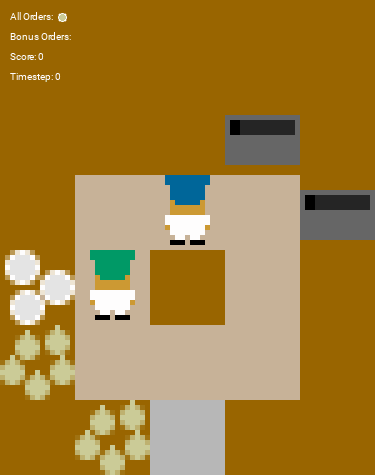

In [ ]:
##############################################################################
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate. Example hooks to Google drive are commented.
img_dir =  "imgs/" # "/content/drive/My Drive/Colab/" + "imgs_" + layout + "/"
ipython_display = True
gif_path = "imgs/imgs.gif" # "/content/drive/My Drive/Colab/" + layout + ".gif"

StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)

## Uncomment for GIF to be generated and stored in 'gif_path'. Requires 'img_dir'
## to point to a directory of saved images.
img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_list = sorted(img_list, key=lambda x: int(x.split('.')[0]))
images = [Image.open(img_dir + img).convert('RGBA') for img in img_list]
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
with open(gif_path, 'rb') as f: display(IPImage(data=f.read(), format='png'))

# Shared Policy & Critic PPO

In [ ]:
class SharedPolicyFFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.agent_0_head = nn.Linear(128, n_outputs)
        self.agent_1_head = nn.Linear(128, n_outputs)

    def forward(self, x):
        z = self.linear_relu_stack(x)
        agent_0_logits = self.agent_0_head(z)
        agent_1_logits = self.agent_1_head(z)
        return agent_0_logits, agent_1_logits

class CriticFFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class SharedPolicyCriticPPOAgent:
    def __init__(self, actor: SharedPolicyFFNN, critic: CriticFFNN, hparams: dict):
        self.actor = actor
        self.critic = critic
        self.critic_loss_fn = nn.MSELoss()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=hparams['actor_lr'], eps=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=hparams['critic_lr'], eps=1e-5)

        self.gamma = hparams['gamma']       # Discount factor
        self.lambda_ = hparams['lambda']    # Decay factor when calculating GAE
        self.batch_size = hparams['batch_size']
        self.n_epochs = hparams['n_epochs']
        self.epsilon = hparams['epsilon']
        self.target_kl_div = hparams['target_kl_div']
        self.entropy_coeff = hparams['entropy_coeff']
        self.entropy_coeff_start = hparams['entropy_coeff']
        self.max_grad_norm = hparams['max_grad_norm']

    def update_lr(self, lr_decay: float) -> None:
        new_actor_lr = hparams['actor_lr'] * lr_decay
        new_critic_lr = hparams['critic_lr'] * lr_decay
        self.actor_optimizer.param_groups[0]["lr"] = new_actor_lr
        self.critic_optimizer.param_groups[0]["lr"] = new_critic_lr

        self.entropy_coeff = max(self.entropy_coeff_start*lr_decay, 0.1)

    def calculate_disconted_returns(self, rewards: list) -> np.ndarray:
        """Given a list of rewards at each timestep of episode, it calculates
        the return from each timestep
        """
        discounted = np.array(rewards, dtype=float)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += self.gamma * discounted[step + 1]
        return discounted

    def calculate_generalized_advantage_estimates(self, rewards: list, values: list) -> np.ndarray:
        """Given a list of reewards, and values for each timestep,
        returns the Generarlized Estimate Advantage:
        A_t = sigma{l=0, inf} (γλ)^l δ_(t+l)
        A_t^λ = r_t + γ * V(s_{t+1}) - V(s_t) + λ * A_{t+1}^λ

        Eg: calculate_generalized_advantage_estimates(
            [7, 3, 2, 2], [10, 5, 1, 1]) -> array([3.22 , 1.59, 2.87, 1.00])
        """
        next_values = np.concatenate([values[1:], [0]])
        td_errors = [(r + self.gamma * next_val) - val for r, val, next_val in zip(rewards, values, next_values)]

        gaes = [td_errors[-1]]
        for i in reversed(range(len(td_errors)-1)):
            gaes.append(td_errors[i] + (self.lambda_ * self.gamma * gaes[-1]))

        return np.array(gaes[::-1])

    def get_action_from_logits(self, logits: torch.Tensor) -> tuple:
        actions_distr = Categorical(logits=logits)
        action = actions_distr.sample()
        action_log_prob = actions_distr.log_prob(action)
        return action.item(), action_log_prob.item()

    def select_actions(self, state: np.ndarray) -> tuple:
        """Returns action (int) and its log probability(float)"""
        tensor_state = torch.from_numpy(state).float()
        self.actor.eval()
        with torch.no_grad():
            agent_0_logits, agent_1_logits = self.actor(tensor_state)
        action_0, action_0_log_prob = self.get_action_from_logits(agent_0_logits)
        action_1, action_1_log_prob = self.get_action_from_logits(agent_1_logits)

        return action_0, action_0_log_prob, action_1, action_1_log_prob

    def compute_value(self, state: np.ndarray) -> float:
        """Returns the value of the state by calling the critic"""
        tensor_state = torch.from_numpy(state).float()
        self.critic.eval()
        with torch.no_grad():
            value = self.critic(tensor_state)

        return value.item()

    def critic_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of critic training"""
        self.critic.train()
        # 1) Calculate returns
        combined_retruns = np.array(trajectory.combined_returns)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_combined_states = torch.from_numpy(np.array(trajectory.combined_states)[mb_indices]).float()  # shape = (batch_size, state_size)
                mb_combined_retruns = torch.from_numpy(combined_retruns[mb_indices]).float().unsqueeze(1)        # shape = (batch_size, 1)

                mb_predicted_combined_retruns = self.critic(mb_combined_states)                               # shape = (batch_size, 1)

                # 4) Compute loss
                loss = self.critic_loss_fn(mb_combined_retruns, mb_predicted_combined_retruns)                # shape = float tensor

                # 5) Backpropagate the gradients
                self.critic_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()        # update weights

    def compute_single_agent_policy_loss(
            self, trajectory: EpisodeTrajectory, mb_indices: np.array,
            both_agents_logits: torch.Tensor, agent_idx: int) -> torch.Tensor:
        """Computes the poilcy loss for a single agent"""
        # 3) Sample a mini-batch of data
        mb_actions = torch.from_numpy(np.array(trajectory.actions)[mb_indices])                    # shape = (batch_size,)
        mb_action_log_probs = torch.from_numpy(np.array(trajectory.action_log_probs)[mb_indices])  # shape = (batch_size,)
        mb_gaes = torch.from_numpy(np.array(trajectory.gaes)[mb_indices]).float()                  # shape = (batch_size,)

        # 4) Calculate the new_log_probs
        new_logits = both_agents_logits[agent_idx]                              # shape = (batch_size, 6)
        new_action_distr = Categorical(logits=new_logits)
        new_log_probs = new_action_distr.log_prob(mb_actions)                   # shape = (batch_size,)
        entropy = new_action_distr.entropy()                                    # shape = (batch_size,)

        # 5) Calculate the ratio
        policy_ratio = torch.exp(new_log_probs - mb_action_log_probs)           # shape = (batch_size,)
        clipped_ratio = policy_ratio.clamp(1-self.epsilon, 1+self.epsilon)

        # 6) Calculate the unclipped and clipped_loss, and then loss
        unclipped_loss = policy_ratio * mb_gaes                                 # shape = (batch_size,)
        clipped_loss = clipped_ratio * mb_gaes                                  # shape = (batch_size,)
        loss = (-torch.min(unclipped_loss, clipped_loss)).mean()                # shape = float tensor
        entropy_loss = entropy.mean()                                           # shape = float tensor
        loss = loss - (self.entropy_coeff * entropy_loss)                       # shape = float tensor

        kl_div = (mb_action_log_probs - new_log_probs).mean()

        return loss, kl_div

    def actor_training_step(self, agent_0_trajectory: EpisodeTrajectory, agent_1_trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of actor training"""
        self.actor.train()

        # 1) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(agent_0_trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 2) Do forward pass
                mb_states = torch.from_numpy(np.array(agent_0_trajectory.combined_states)[mb_indices]).float()     # shape = (batch_size, state_size)
                both_agents_logits = self.actor(mb_states)

                # Compute losses
                agent_0_loss, kl_div_0 = self.compute_single_agent_policy_loss(agent_0_trajectory, mb_indices, both_agents_logits, 0)
                agent_1_loss, kl_div_1 = self.compute_single_agent_policy_loss(agent_1_trajectory, mb_indices, both_agents_logits, 1)
                loss = agent_0_loss + agent_1_loss

                # 7) Backpropagate the gradients
                self.actor_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()         # update weights

            # 8) Stop if policy is changing too much
            kl_div = (kl_div_0 + kl_div_1) / 2
            if kl_div >= self.target_kl_div:
                break

In [ ]:
def get_episode_trajectory_shared_policy_and_critic(n_episodes: int, env, agent: SharedPolicyCriticPPOAgent, stats: dict):
    """Plays an episode and returns the trajectory, which is a tuple of
    (states, actions, action_log_probs, rewards, next_states, value_of_states, dones)
    Each of these elements is of length: episode_lenght,
        state: (ep_len, state_size) eg(400, 96)
        action: (ep_len,) eg(400,)
        action_log_prob: (ep_len,) eg(400,)
        reward: (ep_len,) eg(400,)
        next_state: (ep_len, state_size) eg(400, 96)
        value_of_state: (ep_len,) eg(400,)
        dones: (ep_len,) eg(400,)
    """
    episode_rewards = []
    agent_0_shaped_episode_rewards = []
    agent_1_shaped_episode_rewards = []

    agent_0_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [], [], [], [])
    agent_1_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [], [], [], [])

    for episode_idx in range(n_episodes):
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        obs = env.reset()
        state_0, state_1 = obs["both_agent_obs"]

        for step in range(horizon):
            # 1) Select actions
            combined_state = np.concatenate((state_0, state_1), axis=0)
            action_0, action_log_prob_0, action_1, action_log_prob_1 = agent.select_actions(combined_state)

            # 2) Take actions on env
            obs, common_reward, done, info = env.step([action_0, action_1])
            next_state_0, next_state_1 = obs["both_agent_obs"]

            # 3) Record transition data
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env.agent_idx)


            combined_value = agent.compute_value(combined_state)

            agent_0_trajectory.append(
                state_0, action_0, action_log_prob_0, common_reward+r_shaped_0,
                next_state_0, combined_value, done,
                combined_state, common_reward+r_shaped_0+r_shaped_1)
            agent_1_trajectory.append(
                state_1, action_1, action_log_prob_1, common_reward+r_shaped_1,
                next_state_1, combined_value, done,
                combined_state, common_reward+r_shaped_0+r_shaped_1)

            # 5a) Record rewards
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1
            # 5b) Update states
            state_0, state_1 = next_state_0, next_state_1

        # Calculate end of episode metrics: retruns and gaes
        for agent_, agent_trajectory in [(agent, agent_0_trajectory), (agent, agent_1_trajectory)]:
            # a) caculate retruns
            returns_at_each_episode_timestep = list(agent_.calculate_disconted_returns(agent_trajectory.rewards[-step-1:]))
            agent_trajectory.returns += returns_at_each_episode_timestep
            # b) calculate combined returns
            combined_returns_at_each_episode_timestep = list(agent_.calculate_disconted_returns(agent_trajectory.both_agent_rewards[-step-1:]))
            agent_trajectory.combined_returns += combined_returns_at_each_episode_timestep
            # c) calculate gaes
            gaes_at_each_episode_timestep = list(
                agent_.calculate_generalized_advantage_estimates(
                    agent_trajectory.both_agent_rewards[-step-1:], agent_trajectory.value_of_states[-step-1:]))
            agent_trajectory.gaes += gaes_at_each_episode_timestep

        # Record rewards and stats over the episode
        episode_rewards.append(episode_reward)
        agent_0_shaped_episode_rewards.append(agent_0_shaped_episode_reward)
        agent_1_shaped_episode_rewards.append(agent_1_shaped_episode_reward)
        for stat in stats:
            agent_0_stat_total_over_ep, agent_1_stat_total_over_ep = get_stats_for_agents(info, stat, env.agent_idx)
            stats[stat][0].append(agent_0_stat_total_over_ep)
            stats[stat][1].append(agent_1_stat_total_over_ep)

    return agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards

In [ ]:
hparams = {
    'gamma': 0.95,
    'lambda': 0.97,
    'batch_size': 512,
    'n_epochs': 10,
    'actor_lr': 4e-4,
    'critic_lr': 4e-4,
    'epsilon': 0.2,
    'target_kl_div': 0.02,
    'entropy_coeff': 0.20,
    'max_grad_norm': 0.5,
    'max_iters': 1000,
}

# ppo_layout = 'cramped_room'
# ppo_layout = "asymmetric_advantages"
# ppo_layout = "coordination_ring"
# ppo_layout = "forced_coordination"
ppo_layout = "counter_circuit_o_1order"

In [ ]:
# ## Curriculum learning
# agent.actor_optimizer.param_groups[0]["lr"] = hparams['actor_lr']
# agent.critic_optimizer.param_groups[0]["lr"] = hparams['critic_lr']

# agent.entropy_coeff = hparams['entropy_coeff']

# agent.entropy_coeff

In [ ]:
def train_shared_policy_and_critic_ppo_agent(run_name: str):
    # Set Up
    env_ = build_env(ppo_layout)
    # env_.reset(seed=42)
    input_shape = env_.observation_space.shape
    n_outputs = env_.action_space.n

    shared_actor = SharedPolicyFFNN(input_shape[0]*2, n_outputs)
    shared_critic = CriticFFNN(input_shape[0]*2, 1)
    agent = SharedPolicyCriticPPOAgent(shared_actor, shared_critic, hparams)

    num_iters = 1000
    n_episodes_per_trajectory = 10
    episode_idx = 0

    # Do training
    total_reward_per_episode = []
    average_episode_reward_over_last_100 = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    run_info = {}
    # Each value is a list of two lists, one for each agent. The value in each
    # sub-list represents the number of, say onion_pickups, in each episode
    # over the training
    stats = {'onion_pickup': [[], []], 'useful_onion_pickup': [[], []], 'potting_onion': [[], []],
             'dish_pickup': [[], []], 'useful_dish_pickup': [[], []],
             'soup_pickup': [[], []], 'soup_delivery': [[], []]}

    for iter_idx in range(num_iters):
        # 1) Play an episode
        agent_0_trajectory, agent_1_trajectory, episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards = get_episode_trajectory_shared_policy_and_critic(
            n_episodes_per_trajectory, env_, agent, stats)

        # 2) Update learning rate
        lr_decay = 1.0 - ((iter_idx) / hparams['max_iters'])
        agent.update_lr(lr_decay)

        # 3) Do training step
        agent.actor_training_step(agent_0_trajectory, agent_1_trajectory)
        agent.critic_training_step(agent_0_trajectory)

        # 4) Record results and log info
        total_reward_per_episode += episode_rewards
        agent_0_total_shaped_reward_per_episode += agent_0_shaped_episode_rewards
        agent_1_total_shaped_reward_per_episode += agent_1_shaped_episode_rewards

        # Checkpoint
        if episode_idx % 100 == 0:
            average_episode_reward_over_last_100.append(np.mean(total_reward_per_episode[-100:]))
        if episode_idx % 50 == 0:
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")

        # Print out debug
        for episode_reward, agent_0_shaped_episode_reward, agent_1_shaped_episode_reward in zip(
            episode_rewards, agent_0_shaped_episode_rewards, agent_1_shaped_episode_rewards):
            print(f"\rEpisode: {episode_idx} " +
                  f"episode_reward: {episode_reward}, " +
                  f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
                  f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward} "
                  f"average_episode_reward_over_last_100: {average_episode_reward_over_last_100[-1]}", end="")
            episode_idx += 1

        # Check for convergence
        min_reward = 140
        if ((average_episode_reward_over_last_100[-1] > min_reward and np.all(np.array(total_reward_per_episode[-5:]) >= min_reward)) or
            np.all(np.array(total_reward_per_episode[-20:]) >= min_reward)):
            checkpoint(run_name, episode_idx, run_info, total_reward_per_episode, average_episode_reward_over_last_100,
                       agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, stats, "during_training")
            print(f"\nConverged: Achieved an average reward >140 on episode {episode_idx}")
            break

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent, stats

In [ ]:
run_name = "run22"

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, agent, stats = train_shared_policy_and_critic_ppo_agent(run_name)

Episode: 4619 episode_reward: 0, agent_0_shaped_episode_reward: 24, agent_1_shaped_episode_reward: 50 average_episode_reward_over_last_100: 0.0

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.array(stats['onion_pickup']).sum(axis=0), label="onion_pickup")
plt.plot(np.array(stats['useful_onion_pickup']).sum(axis=0), label="useful_onion_pickup")
plt.plot(np.array(stats['dish_pickup']).sum(axis=0), label="dish_pickup")
plt.plot(np.array(stats['soup_pickup']).sum(axis=0), label="soup_pickup")
plt.plot(np.array(stats['soup_delivery']).sum(axis=0), label="soup_delivery")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper center', fontsize=10)  # Add legend to distinguish the lines
# plt.savefig(f"{dir_path}{run_name}_during_training.png")
plt.show()

In [ ]:
def play_n_episodes(num_episodes: int, agent: SharedPolicyCriticPPOAgent):
    """After training, simply play n episodes using optimal action"""
    total_reward_per_episode = []
    agent_0_total_shaped_reward_per_episode = []
    agent_1_total_shaped_reward_per_episode = []
    env_ = build_env(ppo_layout)

    for episode_idx in range(num_episodes):
        obs = env_.reset()
        state_0, state_1 = obs["both_agent_obs"]
        episode_reward = 0
        agent_0_shaped_episode_reward = 0
        agent_1_shaped_episode_reward = 0

        for step in range(horizon):
            # 1) Select actions
            combined_state = np.concatenate((state_0, state_1), axis=0)
            action_0, action_log_prob_0, action_1, action_log_prob_1 = agent.select_actions(combined_state)

            # 2) Take actions on env
            obs, common_reward, done, info = env_.step([action_0, action_1])

            # 3) Update state
            state_0, state_1 = obs["both_agent_obs"]

            # 4) Record rewards
            r_shaped_0, r_shaped_1 = get_shaped_rewards_for_agents(info, env_.agent_idx)
            episode_reward += common_reward
            agent_0_shaped_episode_reward += r_shaped_0
            agent_1_shaped_episode_reward += r_shaped_1

        total_reward_per_episode.append(episode_reward)
        agent_0_total_shaped_reward_per_episode.append(agent_0_shaped_episode_reward)
        agent_1_total_shaped_reward_per_episode.append(agent_1_shaped_episode_reward)

        print(f"\rEpisode: {episode_idx}, " +
              f"episode_reward: {episode_reward}, " +
              f"agent_0_shaped_episode_reward: {agent_0_shaped_episode_reward}, "
              f"agent_1_shaped_episode_reward: {agent_1_shaped_episode_reward}", end="")

    checkpoint(run_name, episode_idx, {}, total_reward_per_episode, [],
                agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode, {}, "after_training")

    return total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

Episode: 99, episode_reward: 140, agent_0_shaped_episode_reward: 63, agent_1_shaped_episode_reward: 93

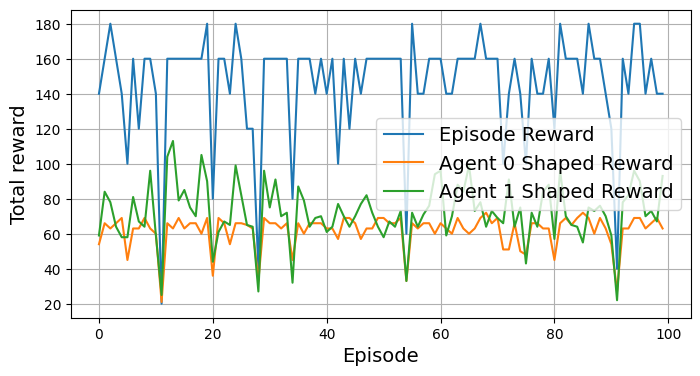

In [ ]:
total_reward_per_episode, agent_0_total_shaped_reward_per_episode, agent_1_total_shaped_reward_per_episode = play_n_episodes(100, agent)

plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.plot(agent_0_total_shaped_reward_per_episode, label="Agent 0 Shaped Reward")
plt.plot(agent_1_total_shaped_reward_per_episode, label="Agent 1 Shaped Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{dir_path}{run_name}_after_training.png")
plt.show()